# Twitter Sentiment Analysis: Toronto Tweets
By: Jennifer Johnson

Exploratory Data Analysis on Twitter data filtered for Toronto Only

In [1]:
import pandas as pd
import re
import spacy
import nltk
import string
import ast
import numpy as np
import seaborn as sns

import missingno as msno

from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid") 

In [2]:
spacy.load('en')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jennifer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jennifer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jennifer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from translate import Translator

parser = English()
translator = Translator(to_lang="English")

In [4]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [5]:
# Filter out stopwords
en_stop = set(nltk.corpus.stopwords.words('english'))

In [6]:
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [7]:
def processTweet(tweet):
    # process the tweets
    translator = str.maketrans('', '', string.punctuation)

    #Convert to lower case
    tweet = tweet.lower()
    
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    
    ## Add
    # Update negations (isn't to is not)
    tweet = neg_pattern.sub(lambda x: negations_dic[x.group()], tweet)
    
    # Remove all non-alpha characers
    tweet = re.sub("[^a-zA-Z]", " ", tweet)    
    ##
    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #trim
    tweet = tweet.strip('\'"')
    
    #remove punctuation from text
    tweet = tweet.translate(translator)    
    
    tweet = tweet.split()
    tweet = [get_lemma(token) for token in tweet]
    tweet = [token for token in tweet if token not in en_stop]
    tweet = ' '.join(tweet)
    return tweet

In [8]:
# Load dataframe
tweets_df = pd.read_csv('D:/development/CSDA1050/playground/twitter_jj/twitter_tweets_new.csv')
tweets_df = tweets_df[tweets_df['place_country']=='Canada']
tweets_df.shape

(299111, 24)

In [9]:
# changing tweet_text to String column (returned error about 'float')
# when full dataset was used
tweets_df['tweet_text'] = tweets_df['tweet_text'].astype(str)
tweets_df['tweet_clean'] = tweets_df['tweet_text'].apply(processTweet)

In [10]:
import pytz

In [11]:
def getTZ(tweet_date):
    est = pytz.timezone('US/Eastern')
    
    tweet_date = pd.Timestamp(tweet_date).tz_localize('UTC')
    tweet_date = tweet_date.astimezone(est)
    
    return tweet_date

In [12]:
# changing tweet_date to DateTime column
tweets_df.tweet_date = pd.to_datetime(tweets_df['tweet_date'])
tweets_df['tweet_date'] = tweets_df['tweet_date'].apply(getTZ)

In [13]:
# split sentiment
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x:dict(eval(x)))
tweets_sent = tweets_df['sentiment'].apply(pd.Series)
tweets_df = pd.concat([tweets_df, tweets_sent], axis=1).drop('sentiment', axis=1)
tweets_df['sentiment'] = None
tweets_df.loc[tweets_df['compound'] >= 0.05, 'sentiment'] = 'positive'
tweets_df.loc[(tweets_df['compound'] > -0.05) & (tweets_df['compound'] < 0.05), 'sentiment'] = 'neutral'
tweets_df.loc[tweets_df['compound'] <= -0.05, 'sentiment'] = 'negative'

In [14]:
tweets_df.head()

,emojis,hashtags,id,language,latitude,longitude,mentions,place_bbcoordinates,place_bbtype,place_country,...,tweet_date,tweet_text,user_id,user_name,tweet_clean,neg,neu,pos,compound,sentiment
0,[':red_heart:'],NaN,1107369998148788224,en,NaN,NaN,NaN,"[[[-79.583667, 43.550871], [-79.583667, 43.550...",Polygon,Canada,...,2019-03-17 15:55:56.155000-04:00,Loving the vibes :red_heart:️ https://t.co/X8v...,908049944040361984,wikki_87,love vibes red heart,0.000,0.506,0.494,0.5994,positive
1,[],NaN,1107370010182324229,und,NaN,NaN,"['Rosalestri', 'Cnyari']","[[[-80.248423, 43.050553], [-80.248423, 43.470...",Polygon,Canada,...,2019-03-17 15:55:59.024000-04:00,@Rosalestri @Cnyari Olé,16801721,njsh2008,ol,0.000,1.000,0.000,0.0000,neutral
4,"[':fearful_face:', ':fearful_face:', ':flushed...",NaN,1107370005883023360,ko,NaN,NaN,['BTS_twt'],"[[[-95.155898, 41.676329], [-95.155898, 56.852...",Polygon,Canada,...,2019-03-17 15:55:57.999000-04:00,"@BTS_twt 김태형, 밴드에이드? :fearful_face::fearful_fa...",828139192035196928,BangtanBabeXO,fearful face fearful face wa cut hope hurt muc...,0.187,0.510,0.304,0.5330,positive
5,[],NaN,1107370047134224384,en,NaN,NaN,['MazharAbbasGEO'],"[[[-79.810142, 43.373074], [-79.810142, 43.737...",Polygon,Canada,...,2019-03-17 15:56:07.834000-04:00,@MazharAbbasGEO WHAT ABOUT THIS SHAMELESS http...,127687121,ZA_chaudhry,shameless,0.423,0.577,0.000,-0.5670,negative
6,[],"['torontocontractors', 'renovation', 'interior...",1107370085608538113,en,43.7166,-79.3407,NaN,"[[[-79.639319, 43.403221], [-79.639319, 43.855...",Polygon,Canada,...,2019-03-17 15:56:17.007000-04:00,"Before and after, big different....\n.\n.\n.\n...",349291874,905RENO,big different torontocontractors renovation in...,0.000,1.000,0.000,0.0000,neutral


## Trend of Sentiment Over Time

In [15]:
tweets_df['tweet_dt']= tweets_df['tweet_date'].dt.normalize()
# Number of Tweets by Day and Sentiment
tweets_day = tweets_df.groupby(['tweet_dt', 'sentiment'])['id'].count().reset_index(name='count')
tweets_day.head()

,tweet_dt,sentiment,count
0,2019-03-17 00:00:00-04:00,negative,1188
1,2019-03-17 00:00:00-04:00,neutral,2824
2,2019-03-17 00:00:00-04:00,positive,2679
3,2019-03-18 00:00:00-04:00,negative,1796
4,2019-03-18 00:00:00-04:00,neutral,3630


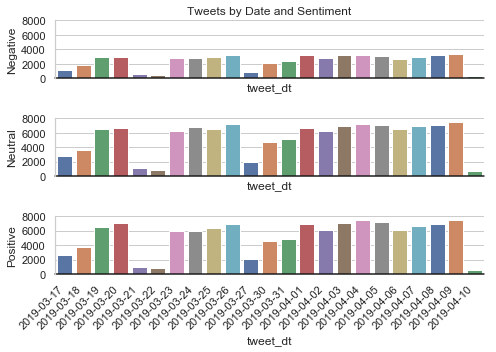

In [38]:
f, (ax1, ax2, ax3) =  plt.subplots(3, 1, figsize=(7, 5), sharex=True)
sns.barplot(x='tweet_dt', y='count', palette='deep', ax=ax1, 
            data=tweets_day[tweets_day.sentiment=='negative'])
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Negative")
ax1.axes.set_title("Tweets by Date and Sentiment")

sns.barplot(x='tweet_dt', y='count', palette='deep', ax=ax2, 
            data=tweets_day[tweets_day.sentiment=='neutral'])
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Neutral")

sns.barplot(x='tweet_dt', y='count', palette='deep', ax=ax3, 
            data=tweets_day[tweets_day.sentiment=='positive'])
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Positive")

x_dates = tweets_df['tweet_dt'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax3.set_xticklabels(labels=x_dates, rotation=45, ha='right')

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[0, 2000, 4000, 6000, 8000])
plt.tight_layout(h_pad=2)

In [39]:
tweets_df['tweet_hour']= tweets_df.tweet_date.dt.hour
# Number of Tweets by Time of Day and Sentiment
tweets_tod = tweets_df.groupby(['tweet_hour', 'sentiment'])['id'].count().reset_index(name='count')
tweets_tod.head()

,tweet_hour,sentiment,count
0,0,negative,1904
1,0,neutral,4218
2,0,positive,3427
3,1,negative,1246
4,1,neutral,2661


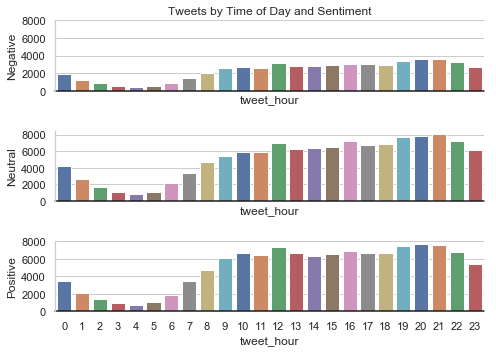

In [41]:
f, (ax1, ax2, ax3) =  plt.subplots(3, 1, figsize=(7, 5), sharex=True)
sns.barplot(x='tweet_hour', y='count', palette='deep', ax=ax1, 
            data=tweets_tod[tweets_tod.sentiment=='negative'])
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Negative")
ax1.axes.set_title("Tweets by Time of Day and Sentiment")

sns.barplot(x='tweet_hour', y='count', palette='deep', ax=ax2, 
            data=tweets_tod[tweets_tod.sentiment=='neutral'])
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Neutral")

sns.barplot(x='tweet_hour', y='count', palette='deep', ax=ax3, 
            data=tweets_tod[tweets_tod.sentiment=='positive'])
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Positive")


#ax3.set_xticklabels()

sns.despine(bottom=True)
plt.setp(f.axes, yticks=[0, 2000, 4000, 6000, 8000])
plt.tight_layout(h_pad=2)

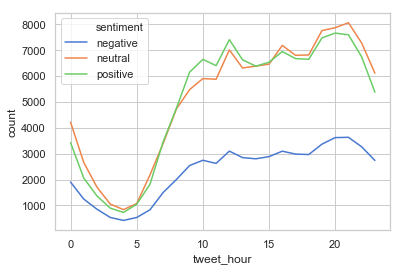

In [53]:
sns.lineplot(x='tweet_hour', y='count', hue='sentiment',
             palette='muted', data=tweets_tod)


In [43]:
tweets_df['tweet_dow']= pd.to_datetime(tweets_df['tweet_date']).dt.dayofweek
# Number of Tweets by Day of Week and Sentiment
tweets_dow = tweets_df.groupby(['tweet_dow', 'sentiment'])['id'].count().reset_index(name='count')
tweets_dow.head()

,tweet_dow,sentiment,count
0,0,negative,11093
1,0,neutral,23948
2,0,positive,23811
3,1,negative,12334
4,1,neutral,27391


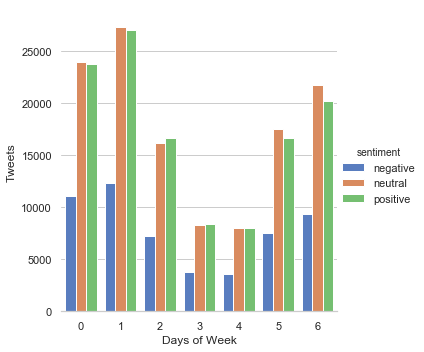

In [51]:
#f, (ax1, ax2, ax3) =  plt.subplots(3, 1, figsize=(7, 5), sharex=True)
#lt.figure(figsize=(16,10))
g = sns.catplot(x='tweet_dow', y='count', hue='sentiment', 
            palette='muted', data=tweets_dow, kind='bar')

g.despine(left=True)
g.set_ylabels('Tweets')
g.set_xlabels('Days of Week')


In [66]:
all_tweets = tweets_df[tweets_df.hashtags.notnull()]

all_tweets['hashtags'] = all_tweets['hashtags'].apply(ast.literal_eval)
all_tweets['hash'] = all_tweets['hashtags'].apply(', '.join).str.lower()
hash_words = ', '.join([text for text in all_tweets['hash']])
words = nltk.tokenize.word_tokenize(hash_words)
word_dist = nltk.FreqDist(words)

ah = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
ah = ah[ah['Word'].str.len() > 1]
ah.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Word,Frequency
1,toronto,3233
2,mississauga,698
3,ufc,689
4,cdnpoli,638
5,onpoli,575


In [65]:
neg_tweets = tweets_df[tweets_df.hashtags.notnull()]
neg_tweets = neg_tweets[tweets_df.sentiment == 'negative']

neg_tweets['hashtags'] = neg_tweets['hashtags'].apply(ast.literal_eval)
neg_tweets['hash'] = neg_tweets['hashtags'].apply(', '.join).str.lower()
hash_words = ', '.join([text for text in neg_tweets['hash']])
words = nltk.tokenize.word_tokenize(hash_words)
word_dist = nltk.FreqDist(words)

neg = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
neg = neg[neg['Word'].str.len() > 1]
neg.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Word,Frequency
1,cdnpoli,191
2,toronto,159
3,ufc,153
4,onpoli,126
5,news,83


In [64]:
pos_tweets = tweets_df[tweets_df.hashtags.notnull()]
pos_tweets = pos_tweets[tweets_df.sentiment == 'positive']

pos_tweets['hashtags'] = pos_tweets['hashtags'].apply(ast.literal_eval)
pos_tweets['hash'] = pos_tweets['hashtags'].apply(', '.join).str.lower()
hash_words = ', '.join([text for text in pos_tweets['hash']])
words = nltk.tokenize.word_tokenize(hash_words)
word_dist = nltk.FreqDist(words)

pos = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
pos = pos[pos['Word'].str.len() > 1]
pos.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Word,Frequency
1,toronto,1405
2,mississauga,432
3,hamont,264
4,aera19,239
5,ufc,210


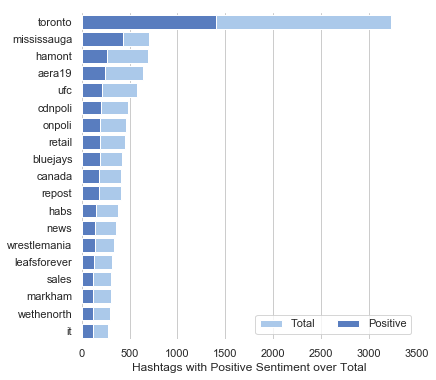

In [74]:
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total hashtags
sns.set_color_codes("pastel")
sns.barplot(x="Frequency", y="Word", data=ah, label="Total", color="b")

# Plot the positive hashtags
sns.set_color_codes("muted")
sns.barplot(x="Frequency", y="Word", data=pos,
            label="Positive", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 3500), ylabel="",
       xlabel="Hashtags with Positive Sentiment over Total")
sns.despine(left=True, bottom=True)

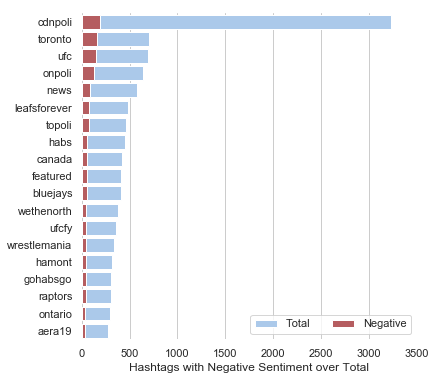

In [80]:
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total hashtags
sns.set_color_codes("pastel")
sns.barplot(x="Frequency", y="Word", data=ah, label="Total", color="b")

# Plot the positive hashtags
sns.set_color_codes("deep")
sns.barplot(x="Frequency", y="Word", data=neg,
            label="Negative", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 3500), ylabel="",
       xlabel="Hashtags with Negative Sentiment over Total")
sns.despine(left=True, bottom=True)

In [84]:
# Filter for tweets with emojis
#tweets_df['emojis'] = tweets_df['emojis'].apply(ast.literal_eval)
tweets_df['emo'] = tweets_df['emojis'].apply(', '.join).str.lower()
emoji_words = ', '.join([text for text in tweets_df['emo']])
tweets_df['emo'] = tweets_df['emo'].str.replace(":,", "").str.strip()

a = tweets_df['emo'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

emo = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
emo = emo[emo['Word'].str.len() > 1]
emo.head()

,Word,Frequency
1,face_with_tears_of_joy,13559
2,loudly_crying_face,5869
3,red_heart,5707
4,rolling_on_the_floor_laughing,4849
5,fire,4368


In [85]:
pe = tweets_df[tweets_df.sentiment == 'positive']
a = pe['emo'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

pemo = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
pemo = pemo[pemo['Word'].str.len() > 1]
pemo.head()

,Word,Frequency
1,face_with_tears_of_joy,3354
2,red_heart,3152
3,smiling_face_with_heart-eyes,1645
4,loudly_crying_face,1508
5,folded_hands,1497


In [87]:
ne = tweets_df[tweets_df.sentiment == 'negative']
a = ne['emo'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

nemo = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
nemo = nemo[nemo['Word'].str.len() > 1]
nemo.head()

,Word,Frequency
1,face_with_tears_of_joy,1883
2,loudly_crying_face,1110
3,rolling_on_the_floor_laughing,662
4,fire,361
5,female_sign,351


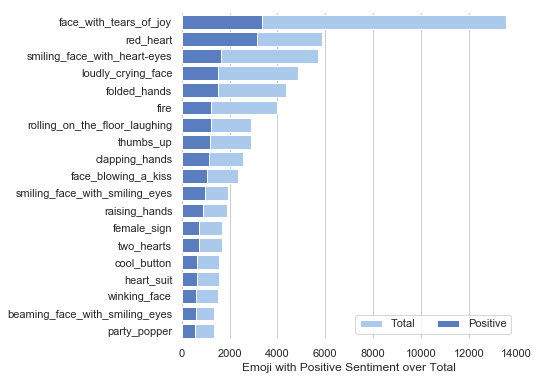

In [89]:
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total hashtags
sns.set_color_codes("pastel")
sns.barplot(x="Frequency", y="Word", data=emo, label="Total", color="b")

# Plot the positive hashtags
sns.set_color_codes("muted")
sns.barplot(x="Frequency", y="Word", data=pemo,
            label="Positive", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 14000), ylabel="",
       xlabel="Emoji with Positive Sentiment over Total")
sns.despine(left=True, bottom=True)

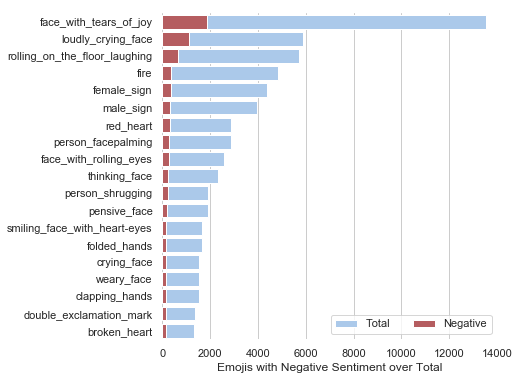

In [90]:
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total hashtags
sns.set_color_codes("pastel")
sns.barplot(x="Frequency", y="Word", data=emo, label="Total", color="b")

# Plot the positive hashtags
sns.set_color_codes("deep")
sns.barplot(x="Frequency", y="Word", data=nemo,
            label="Negative", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 14000), ylabel="",
       xlabel="Emojis with Negative Sentiment over Total")
sns.despine(left=True, bottom=True)

In [91]:
tweets_mentions_df = tweets_df[tweets_df.mentions.notnull()]

tweets_mentions_df['mentions'] = tweets_mentions_df['mentions'].apply(ast.literal_eval)
tweets_mentions_df['ment'] = tweets_mentions_df['mentions'].apply(', '.join).str.lower()
mentions_words = ', '.join([text for text in tweets_mentions_df['ment']])
words = nltk.tokenize.word_tokenize(mentions_words)
word_dist = nltk.FreqDist(words)

men = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
men = men[men['Word'].str.len() > 1]
men.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Word,Frequency
1,fordnation,1515
2,realdonaldtrump,1383
3,justintrudeau,1206
4,andrewscheer,723
5,p_machor,616


In [93]:
#neg_tweets = tweets_df[tweets_df.mentions.notnull()]
neg_tweets = tweets_mentions_df[tweets_mentions_df.sentiment == 'negative']

mentions_words = ', '.join([text for text in neg_tweets['ment']])
words = nltk.tokenize.word_tokenize(mentions_words)
word_dist = nltk.FreqDist(words)

nmen = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
nmen = nmen[nmen['Word'].str.len() > 1]
nmen.head()

,Word,Frequency
1,fordnation,556
2,realdonaldtrump,478
3,justintrudeau,465
4,andrewscheer,282
5,puglaas,192


In [94]:
pos_tweets = tweets_mentions_df[tweets_mentions_df.sentiment == 'positive']

mentions_words = ', '.join([text for text in pos_tweets['ment']])
words = nltk.tokenize.word_tokenize(mentions_words)
word_dist = nltk.FreqDist(words)

pmen = pd.DataFrame(word_dist.most_common(20), columns=['Word', 'Frequency'])
pmen = pmen[pmen['Word'].str.len() > 1]
pmen.head()

,Word,Frequency
1,fordnation,589
2,justintrudeau,445
3,realdonaldtrump,430
4,p_machor,352
5,flash_katie237,293


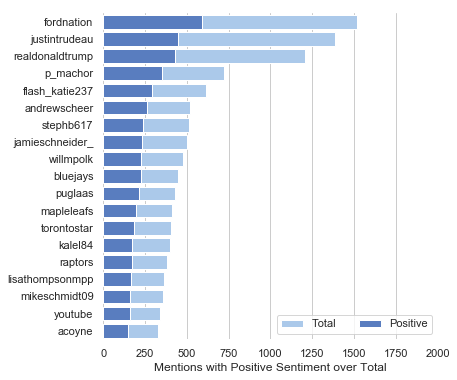

In [96]:
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total hashtags
sns.set_color_codes("pastel")
sns.barplot(x="Frequency", y="Word", data=men, label="Total", color="b")

# Plot the positive hashtags
sns.set_color_codes("muted")
sns.barplot(x="Frequency", y="Word", data=pmen,
            label="Positive", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 2000), ylabel="",
       xlabel="Mentions with Positive Sentiment over Total")
sns.despine(left=True, bottom=True)

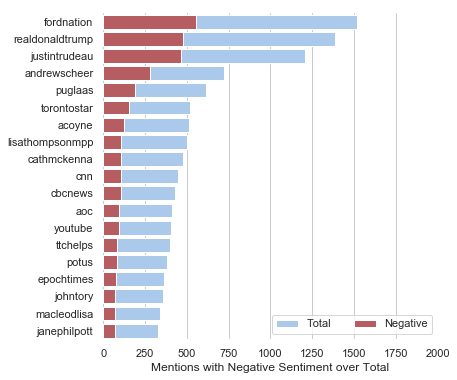

In [98]:
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total hashtags
sns.set_color_codes("pastel")
sns.barplot(x="Frequency", y="Word", data=men, label="Total", color="b")

# Plot the positive hashtags
sns.set_color_codes("deep")
sns.barplot(x="Frequency", y="Word", data=nmen,
            label="Negative", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 2000), ylabel="",
       xlabel="Mentions with Negative Sentiment over Total")
sns.despine(left=True, bottom=True)